In [3]:
# %load gen_data.py
import math
import numpy as np
import matplotlib.pyplot as plt

n_range = 40
n_times = 1000
n_dims = 3
np.random.seed(2)
x = np.empty((n_dims, n_times), 'int64')
start = np.random.randint(-4*n_range, 4*n_range, n_dims).reshape(n_dims, 1)

x[:] = start + np.array(range(n_times)) 
data = np.sin(x / 1.0 / n_range).astype('float64').T
np.save('./data.npy', data)

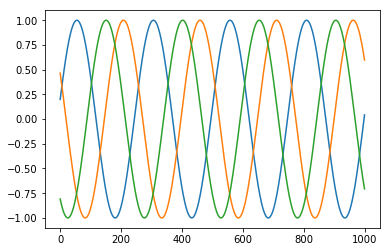

In [4]:
%matplotlib inline
plt.plot(data)

In [1]:
# %load train.py
""" Recurrent Neural Network Time Series.

A Recurrent Neural Network (LSTM) multivariate time series test_preding implementation 
Minimalist example using TensorFlow library.

Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [dataset Dataset](http://yann.lecun.com/exdb/dataset/).
"""

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

# Import dataset data
from reader import read_data_sets
from model import RNN, MRNN, TRNN, MTRNN, LSTM, PLSTM
from train_config import *

'''
To test_pred time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''


# Command line arguments 
flags = tf.flags

flags.DEFINE_string("data_path", "./data.npy",
          "Where the training/test data is stored.")
flags.DEFINE_string("save_path", "/Users/roseyu/Documents/Python/log/",
          "Model output directory.")
flags.DEFINE_bool("use_error_prop", True,
                  "Feed previous output as input in RNN")

flags.DEFINE_integer("hidden_size", 16, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")
flags.DEFINE_integer("num_steps",10,"Training sequence length")
flags.DEFINE_integer("num_test_steps", 10,"Testing sequence length")

FLAGS = flags.FLAGS


# Training Parameters
config = TrainConfig()
# Update config with cmd args
config.hidden_size = FLAGS.hidden_size
config.learning_rate = FLAGS.learning_rate
config.num_steps = FLAGS.num_steps
config.num_test_steps = FLAGS.num_test_steps

training_steps = 1000
display_step = 200
num_steps = config.num_steps
num_test_steps = config.num_test_steps
batch_size = config.batch_size

# Construct dataset
dataset, stats = read_data_sets(FLAGS.data_path, num_steps, num_test_steps)

# Network Parameters
num_input = stats['num_input'] # dataset data input (time series dimension: 3)

# Print exp settings
print('='*80) 

print('|data set|', FLAGS.data_path, '|batch size|', batch_size, '|learn rate|', FLAGS.learning_rate)

print('_'*80)
print('|train steps|', num_steps, '|test steps|', num_test_steps, '|error prop|', config.use_error_prop )

print('='*80)

# Construct train model
with tf.name_scope("Train"):
    # tf Graph train input
    X = tf.placeholder("float", [None, num_steps, num_input])
    Y = tf.placeholder("float", [None, num_steps, num_input])
    with tf.variable_scope("Model", reuse=None):
        train_pred = RNN(X, True, config)
        # Define train loss 
        train_loss = tf.reduce_mean(tf.squared_difference(train_pred, Y))

# Construct test model
with tf.name_scope("Test"):
    # tf Graph test input
    X_test = tf.placeholder("float", [None, num_test_steps, num_input])
    Y_test = tf.placeholder("float", [None, num_test_steps, num_input])
    with tf.variable_scope("Model", reuse=True):      
        test_pred = RNN(X_test, False, config)
        # Define test loss 
        test_loss = tf.reduce_mean(tf.squared_difference(test_pred, Y_test))


# Define optimizer
optimizer = tf.train.RMSPropOptimizer(learning_rate=config.learning_rate)
train_op = optimizer.minimize(train_loss)


# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            tr_loss = sess.run(train_loss, feed_dict={X: batch_x,Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(tr_loss) )
    print("Optimization Finished!")


    # Save the variables to disk.
    save_path = saver.save(sess, FLAGS.save_path)
    print("Model saved in file: %s" % save_path)

   
    # Calculate accuracy for test inps
    test_data = dataset.test.inps.reshape((-1, num_test_steps, num_input))
    test_label = dataset.test.outs

    # Fetch test prediction
    fetches = {
        "true":Y_test,
        "pred":test_pred,
        "loss":test_loss
    }
    vals = sess.run(fetches, feed_dict={X_test: test_data, Y_test: test_label})
    print("Testing Loss:", vals["loss"])


loading time series ...
input type  <class 'numpy.ndarray'> (1000, 3)
|data set| ./data.npy |batch size| 128 |learn rate| 0.01
________________________________________________________________________________
|train steps| 10 |test steps| 10 |error prop| True
Creating model input = ground truth each timestep.
Creating model --> Feeding output back into input.
feed_prev inp shape (?, 3)
t 5 >= 5 --> feeding back output into input.
feed_prev inp shape (?, 3)
t 6 >= 5 --> feeding back output into input.
feed_prev inp shape (?, 3)
t 7 >= 5 --> feeding back output into input.
feed_prev inp shape (?, 3)
t 8 >= 5 --> feeding back output into input.
feed_prev inp shape (?, 3)
t 9 >= 5 --> feeding back output into input.
Step 1, Minibatch Loss= 0.9468
Step 200, Minibatch Loss= 0.0072
Step 400, Minibatch Loss= 0.0041
Step 600, Minibatch Loss= 0.0022
Step 800, Minibatch Loss= 0.0014
Step 1000, Minibatch Loss= 0.0016
Optimization Finished!
Model saved in file: /Users/roseyu/Documents/Python/log/
Te

(90, 10, 3)


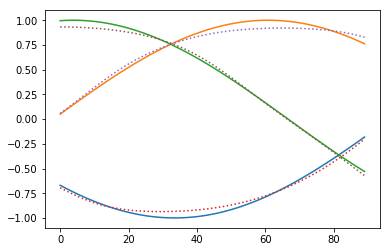

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

y_pred = vals["pred"]
y_true = vals["true"]
print((y_pred.shape))
plt.plot(y_true[:,0,:],'-')
plt.plot(y_pred[:,0,:],':')

(90, 10, 3)


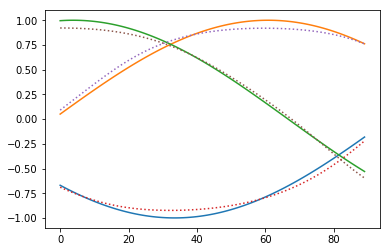

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

y_pred = vals["pred"]
y_true = vals["true"]
print((y_pred.shape))
plt.plot(y_true[:,0,:],'-')
plt.plot(y_pred[:,0,:],':')